# ICT202 Machine Learning

# Assignment 2

_____

# Dataset: Climate Change Tweets Sentiment Analysis

https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset/data

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo.

This dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were annotated. Each tweet is labelled independently by 3 reviewers. This dataset only contains tweets that all 3 reviewers agreed on (the rest were discarded).

Each tweet is labelled as one of the following classes:

2(News): the tweet links to factual news about climate change
1(Pro): the tweet supports the belief of man-made climate change
0(Neutral: the tweet neither supports nor refutes the belief of man-made climate change
-1(Anti): the tweet does not believe in man-made climate change

____

#                          Various Models for Sentiment Analysis

_____

In [2]:
# This script performs the following tasks:
# 1. Initializes an empty dictionary to store file paths.
# 2. Specifies the directory containing the Twitter Climate Change Sentiment Dataset.
# 3. Iterates through the directory and its subdirectories to collect file paths.
# 4. Loads the "twitter_sentiment_data.csv" file into a Pandas DataFrame.
# 5. Displays the shape of the loaded DataFrame to show the number of rows and columns.
# 6. Samples 2000 random rows from the DataFrame for analysis, ensuring reproducibility with a random state.
# 7. Prints the shape of the sampled DataFrame to confirm the sampling process.
import os
import pandas as pd
from pathlib import Path
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import itertools
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from tqdm import tqdm

data = {}
dataset_dir = './Twitter_Climate_Change_Sentiment_Dataset'
for dirname, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        data[filename] = Path(dirname) / filename

tweets_data = pd.read_csv(data["twitter_sentiment_data.csv"])
display(tweets_data.shape)

# Sample for analysis
tweets = tweets_data.sample(n=2000, random_state=42)
print("Sampled shape:", tweets.shape)

(43943, 3)

Sampled shape: (2000, 3)


In [3]:
# This script performs the following tasks:
# 1. Imports the deepcopy function from the copy module to create a deep copy of the DataFrame.
# 2. Calculates the raw number of each sentiment category in the "sentiment" column of the tweets DataFrame.
# 3. Renames the series containing the raw counts to "Raw Number".
# 4. Calculates the normalized (percentage) values of each sentiment category.
# 5. Renames the series containing the normalized counts to "Percentage".
# 6. Concatenates the raw and normalized counts into a single DataFrame and displays it.
# 7. Displays the first few rows of the tweets DataFrame for an initial look at the data.
# 8. Creates a deep copy of the tweets DataFrame for exploratory data analysis (EDA).
# 9. Defines a dictionary to map sentiment numeric values to their corresponding names.
# 10. Applies the sentiment mapping to the "sentiment" column in the EDA DataFrame.
# 11. Displays the first few rows of the updated EDA DataFrame with sentiment names.


from copy import deepcopy

value_counts = tweets["sentiment"].value_counts()
value_counts.name = "Raw Number"
value_normd = tweets["sentiment"].value_counts(normalize=True)
value_normd.name = "Percentage"

display(pd.concat([value_counts, value_normd], axis=1))
display(tweets.head())

eda = deepcopy(tweets)

sentiment_num2name = {
    -1: "Anti",
     0: "Neutral",
     1: "Pro",
     2: "News",
}
eda["sentiment"] = eda["sentiment"].apply(lambda num: sentiment_num2name[num])
eda.head()

,Raw Number,Percentage
1,1013,0.5065
2,404,0.2020
0,389,0.1945
-1,194,0.0970


,sentiment,message,tweetid
34461,0,RT @vincecable: Nice summary. Add climate chan...,955713180684177408
20916,2,RT @CNN: Former US President Obama will speak ...,861896636313817089
14218,1,RT @leftcoastbabe: EPA Sec. #ScottPruitt says ...,839961977766178817
30674,0,RT @jennyb81112: Not much global warming going...,954760066531495936
32400,1,RT @PaulPolman: Increasingly companies have to...,953094505875562496


,sentiment,message,tweetid
34461,Neutral,RT @vincecable: Nice summary. Add climate chan...,955713180684177408
20916,News,RT @CNN: Former US President Obama will speak ...,861896636313817089
14218,Pro,RT @leftcoastbabe: EPA Sec. #ScottPruitt says ...,839961977766178817
30674,Neutral,RT @jennyb81112: Not much global warming going...,954760066531495936
32400,Pro,RT @PaulPolman: Increasingly companies have to...,953094505875562496


# 1 - Data preprocessing & Analysis


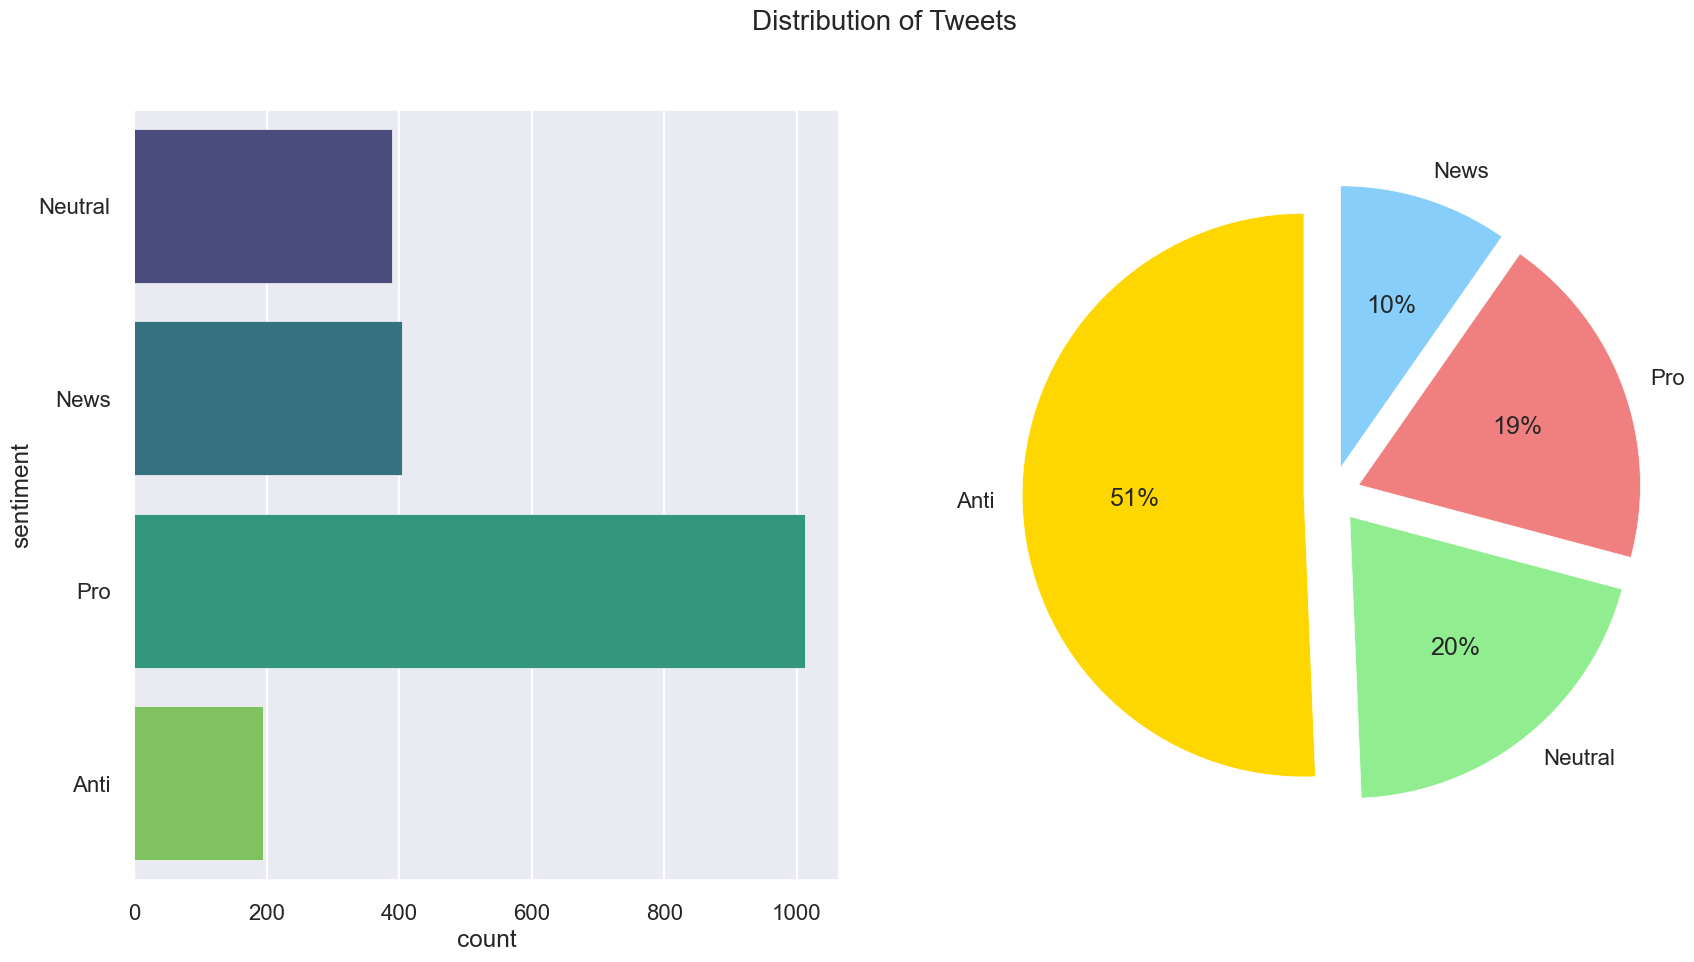

In [4]:
# This script performs the following tasks:
# 1. Imports necessary libraries: matplotlib for plotting and seaborn for enhanced visualization.
# 2. Sets the font scale for seaborn and the style for matplotlib to enhance the visual appeal of the plots.
# 3. Creates a figure with two subplots, specifying the size and resolution.
# 4. Creates a count plot of the "sentiment" column in the eda DataFrame on the first subplot.
# 5. Prepares the labels for the pie chart based on the sentiment mapping.
# 6. Creates a pie chart of the sentiment distribution on the second subplot, with percentage labels, starting angle, and an exploded view for better visual separation.
# 7. Sets the colors of the pie chart segments.
# 8. Adds a title to the figure and displays the plots.



import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
plt.style.use("seaborn-v0_8-poster")

fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=100)

sns.countplot(eda["sentiment"], ax=axes[0], palette="viridis")
labels = list(sentiment_num2name.values())

axes[1].pie(eda["sentiment"].value_counts(),
            labels=labels,
            autopct="%1.0f%%",
            startangle=90,
            explode=tuple([0.1] * len(labels)),
            colors=['gold', 'lightgreen', 'lightcoral', 'lightskyblue'])

fig.suptitle("Distribution of Tweets", fontsize=20)
plt.show()


In [5]:
# This script performs the following tasks:
# 1. Imports necessary libraries: re for regular expressions, nltk for natural language processing, itertools for efficient looping, and warnings to ignore warnings.
# 2. Groups the data by sentiment and processes each group to extract and count the hashtags.
# 3. Finds the top 15 most frequent hashtags for each sentiment and stores them in a dictionary.
# 4. Displays the top 15 hashtags for each sentiment.


import re
import nltk
import itertools
import warnings
warnings.filterwarnings("ignore")

top15 = {}
by_sentiment = eda.groupby("sentiment")
for sentiment, group in tqdm(by_sentiment, desc="Processing Sentiments"):
    hashtags = group["message"].apply(lambda tweet: re.findall(r"#(\w+)", tweet))
    hashtags = itertools.chain(*hashtags)
    hashtags = [ht.lower() for ht in hashtags]

    frequency = nltk.FreqDist(hashtags)

    df_hashtags = pd.DataFrame({
        "hashtags": list(frequency.keys()),
        "counts": list(frequency.values()),
    })

    top15_htags = df_hashtags.nlargest(15, columns=["counts"])
    top15[sentiment] = top15_htags.reset_index(drop=True)

display(pd.concat(top15, axis=1).head(n=10))


Processing Sentiments: 100%|█████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 222.80it/s]


Anti                   Neutral                  News         \
            hashtags counts           hashtags counts       hashtags counts   
0          trumpwins      2      climatechange      3        climate     14   
1               maga      2     beforetheflood      2  climatechange     11   
2      climatechange      2            cdnpoli      2    environment      5   
3               tcot      2            climate      2           news      5   
4              pjnet      2        debatenight      1          trump      4   
5  grandsolarminimum      1        debates2016      1          cop22      3   
6               stfu      1            debates      1    econoticias      2   
7             tucker      1        ornithology      1           wine      2   
8            climate      1            prgrs16      1          exxon      2   
9                alg      1  kateuptonmoveover      1       breaking      2   

              Pro         
         hashtags counts  
0         climate     31  
1   climatechange     13  
2  beforetheflood     13  
3           cop22      6  
4    actonclimate      5  
5           cop21      5  
6   globalwarming      4  
7           trump      4  
8   ivotedbecause      3  
9               ã      3

_____

# Data Cleaning

In [6]:
# This function performs the following tasks:
# 1. Converts the tweet text to lowercase.
# 2. Defines a list of patterns to remove, including usernames, URLs, hashtags, digits, and a specific unicode character.
# 3. Iterates through the list of patterns and removes matches from the tweet using regular expressions.
# 4. Removes punctuation and special characters, replacing them with a space.
# 5. Removes extra whitespace.
# 6. Strips leading whitespace from the cleaned tweet and returns the cleaned text.
# 7. Applies the cleaner function to the 'message' column in the eda DataFrame.
# 8. Displays the first few rows of the updated DataFrame.


def cleaner(tweet):
    tweet = tweet.lower()
    to_del = [r"@[\w]*", r"http(s?):\/\/.*\/\w*", r"#\w*", r"\d+", r"U+FFFD"]
    for key in to_del:
        tweet = re.sub(key, "", tweet)

    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", " ", tweet)
    tweet = re.sub(r"\s\s+", " ", tweet)

    return tweet.lstrip(" ")

eda["message"] = eda["message"].apply(cleaner)
eda.head()

,sentiment,message,tweetid
34461,Neutral,rt nice summary add climate change turning pre...,955713180684177408
20916,News,rt former us president obama will speak about ...,861896636313817089
14218,Pro,rt epa sec says co doesn t cause global warmin...,839961977766178817
30674,Neutral,rt not much global warming going on in texas,954760066531495936
32400,Pro,rt increasingly companies have to deal with fa...,953094505875562496


______

In [7]:
# Import necessary modules for text preprocessing using Natural Language Toolkit (nltk)
# The script includes functions for tokenizing text, tagging parts of speech, converting POS tags,
# and lemmatizing tokens.


from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

def lemmatizer(df):
    df["length"] = df["message"].str.len()
    df["tokenized"] = df["message"].apply(word_tokenize)
    df["parts-of-speech"] = df["tokenized"].apply(nltk.tag.pos_tag)

    def str2wordnet(tag):
        conversion = {"J": wordnet.ADJ, "V": wordnet.VERB, "N": wordnet.NOUN, "R": wordnet.ADV}
        try:
            return conversion[tag[0].upper()]
        except KeyError:
            return wordnet.NOUN

    wnl = WordNetLemmatizer()
    df["parts-of-speech"] = df["parts-of-speech"].apply(
        lambda tokens: [(word, str2wordnet(tag)) for word, tag in tokens]
    )
    df["lemmatized"] = df["parts-of-speech"].apply(
        lambda tokens: [wnl.lemmatize(word, tag) for word, tag in tokens]
    )
    df["lemmatized"] = df["lemmatized"].apply(lambda tokens: " ".join(map(str, tokens)))

    return df

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

eda = lemmatizer(eda)
eda.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,sentiment,message,tweetid,length,tokenized,parts-of-speech,lemmatized
34461,Neutral,rt nice summary add climate change turning pre...,955713180684177408,123,"[rt, nice, summary, add, climate, change, turn...","[(rt, a), (nice, a), (summary, a), (add, n), (...",rt nice summary add climate change turn presid...
20916,News,rt former us president obama will speak about ...,861896636313817089,117,"[rt, former, us, president, obama, will, speak...","[(rt, v), (former, a), (us, n), (president, n)...",rt former u president obama will speak about c...
14218,Pro,rt epa sec says co doesn t cause global warmin...,839961977766178817,97,"[rt, epa, sec, says, co, doesn, t, cause, glob...","[(rt, n), (epa, n), (sec, n), (says, v), (co, ...",rt epa sec say co doesn t cause global warming...
30674,Neutral,rt not much global warming going on in texas,954760066531495936,45,"[rt, not, much, global, warming, going, on, in...","[(rt, n), (not, r), (much, a), (global, a), (w...",rt not much global warm go on in texas
32400,Pro,rt increasingly companies have to deal with fa...,953094505875562496,126,"[rt, increasingly, companies, have, to, deal, ...","[(rt, n), (increasingly, r), (companies, n), (...",rt increasingly company have to deal with fall...


# feature extraction/feature representation

In [8]:
# Import the CountVectorizer module from sklearn for converting text data into numerical data
# Create an empty dictionary 'frequency' to store word frequencies for each sentiment
# Group the DataFrame 'eda' by the 'sentiment' column
# Iterate over each sentiment group and perform the following steps:
# - Initialize a CountVectorizer object to convert text data into a matrix of token counts, ignoring English stop words
# - Fit the CountVectorizer object to the 'lemmatized' text data and transform it into a matrix of token counts
# - Sum the token counts for each word
# - Create a list of tuples containing each word and its corresponding count
# - Sort the list of tuples by count in descending order
# - Convert the sorted list of tuples into a DataFrame with columns 'word' and 'freq'
# - Store the top 25 words and their frequencies for each sentiment in the 'frequency' dictionary
# Concatenate the frequency DataFrames for each sentiment into a single DataFrame
# Display the first 25 rows of the concatenated DataFrame


from sklearn.feature_extraction.text import CountVectorizer

frequency = {}

by_sentiment = eda.groupby("sentiment")
for sentiment, group in tqdm(by_sentiment):
    cv = CountVectorizer(stop_words="english")
    words = cv.fit_transform(group["lemmatized"])

    n_words = words.sum(axis=0)
    word_freq = [(word, n_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

    freq = pd.DataFrame(word_freq, columns=["word", "freq"])
    frequency[sentiment] = freq.head(25)

to_view = pd.concat(frequency, axis=1).head(25)
display(to_view)

100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 37.48it/s]


Anti       Neutral            News             Pro     
           word freq     word freq       word freq       word freq
0       climate  121  climate  230    climate  368     change  835
1        change  118   change  227     change  364    climate  834
2            rt   93   global  173         rt  221         rt  645
3        global   89       rt  159      trump  101     global  204
4       warming   72  warming  140     global   54    warming  152
5          make   17     warm   29        new   33      trump   94
6       believe   14      say   23        say   33    believe   93
7          warm   13     like   21    warming   28        amp   77
8          just   11     real   19        epa   23      think   64
9          real   11    cause   18  scientist   21      doesn   62
10          man   11    trump   18      study   19      world   53
11          say   11  believe   18       plan   18       real   47
12    scientist   10    blame   17       warm   17        say   46
13         year   10       ðÿ   15     donald   17      fight   46
14        obama   10     just   15      china   17     denier   45
15        claim    9      new   13      fight   16     people   44
16      liberal    9      amp   13     report   16       just   43
17        cause    9    world   13      world   15        don   42
18          tax    9      isn   11       make   15       http   42
19         like    8    think   10       http   13       make   40
20          amp    8   people   10      paris   12       deny   38
21        think    8     talk   10     pruitt   11  scientist   38
22       people    8     tell    9     threat   11       warm   38
23  responsible    7      ask    9     action   11       need   37
24      science    7     http    9     policy   11  president   37

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
documents = eda['message']
documents

34461    rt nice summary add climate change turning pre...
20916    rt former us president obama will speak about ...
14218    rt epa sec says co doesn t cause global warmin...
30674        rt not much global warming going on in texas 
32400    rt increasingly companies have to deal with fa...
                               ...                        
27507    if every panchayat starts planting plants ever...
16922    rt corals are affected by lots of things imagi...
6969     rt trump s epa transition team denies human im...
15020    rt “another reason to be worried about climate...
3593     frequently asked questions on climate change a...
Name: message, Length: 2000, dtype: object

In [23]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(documents)

          Word 1    Word 2     Word 3
Topic 1  climate    change     donald
Topic 2  husband  thinking    because
Topic 3   global   warming    weather
Topic 4  believe    people  president


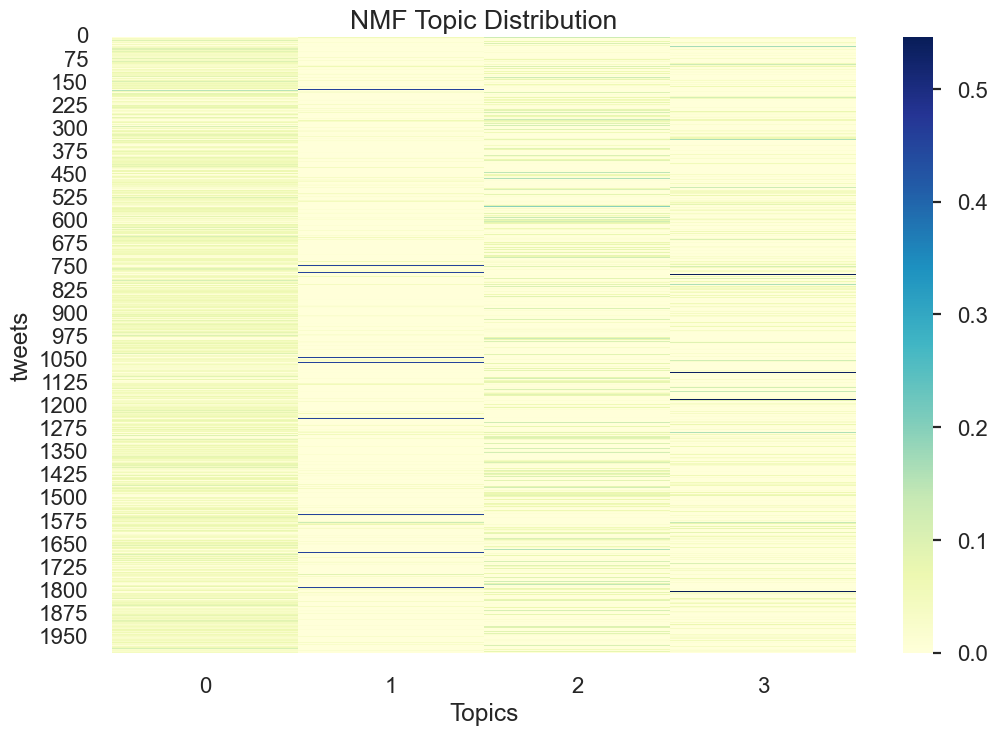

In [44]:

num_topics = 4

# Initialize NMF model with 5 topics, using TF-IDF matrix for fitting
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf)

def get_nmf_topics(model, vectorizer, n_top_words, min_word_length=5):
    words = vectorizer.get_feature_names_out()
    topic_words = []
    for topic in model.components_:
        top_words_idx = topic.argsort()[::-1]  # Sort words by weight in descending order
        top_words = [words[i] for i in top_words_idx if len(words[i]) > min_word_length]
        
        # If there are not enough words meeting the criteria, add more words
        if len(top_words) < n_top_words:
            additional_words = [words[i] for i in top_words_idx if len(words[i]) <= min_word_length]
            top_words.extend(additional_words[:n_top_words - len(top_words)])
        
        topic_words.append(top_words[:n_top_words])
    return topic_words

n_top_words = 3
topic_words = get_nmf_topics(nmf_model, tfidf_vectorizer, n_top_words)

topics_df = pd.DataFrame(topic_words)
topics_df.columns = [f'Word {i+1}' for i in range(n_top_words)]
topics_df.index = [f'Topic {i+1}' for i in range(num_topics)]
print(topics_df)

plt.figure(figsize=(12, 8))
sns.heatmap(nmf_topics, cmap="YlGnBu")
plt.xlabel("Topics")
plt.ylabel("tweets")
plt.title("NMF Topic Distribution")
plt.show()

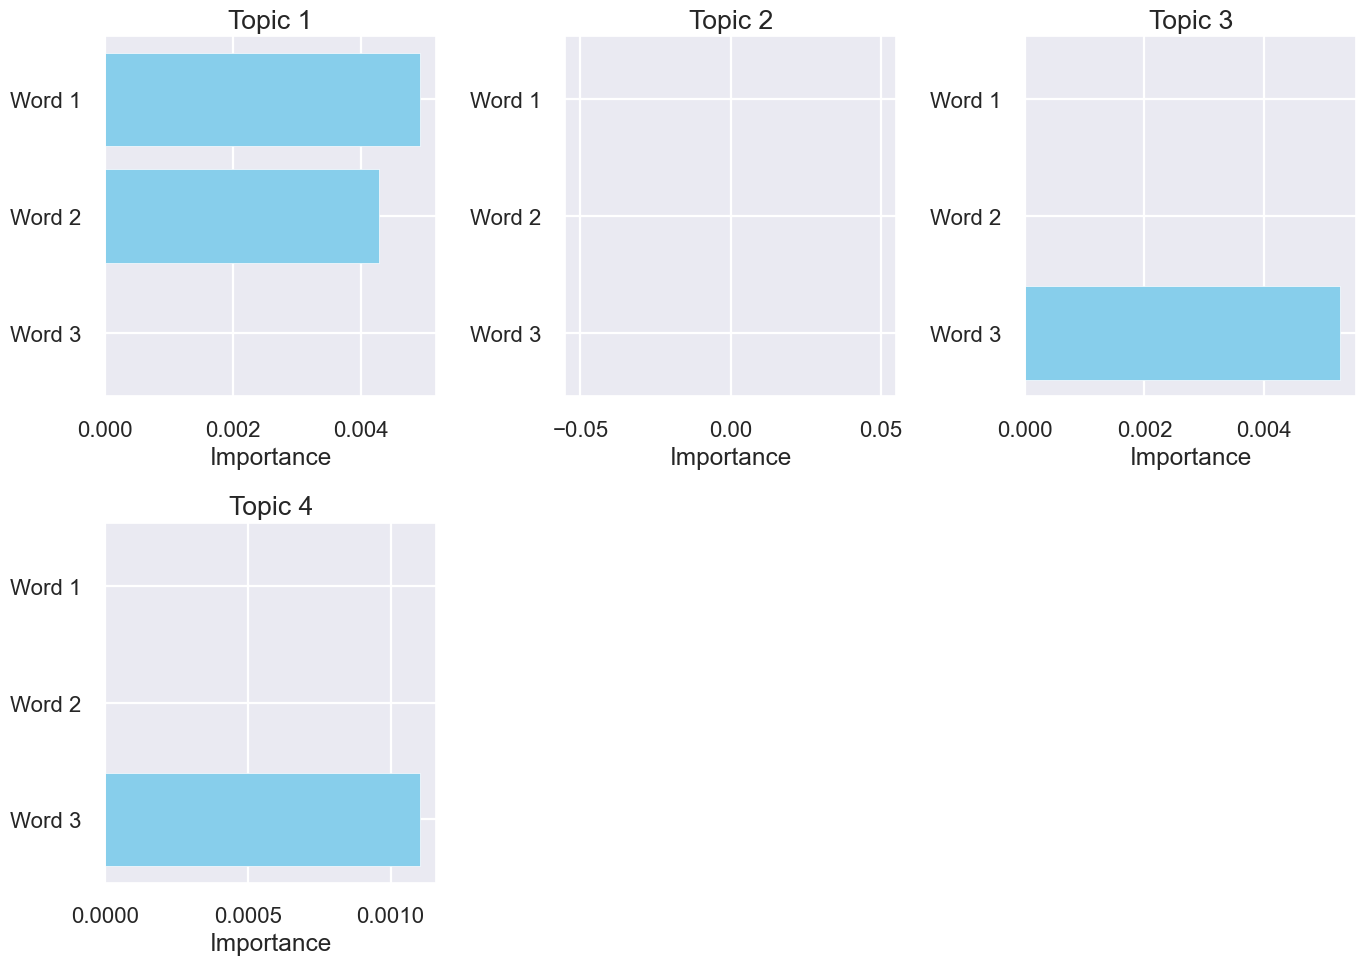

In [45]:
plt.figure(figsize=(14, 10))
for i in range(num_topics):
    plt.subplot(2, 3, i+1)  # Adjust subplot layout if more topics
    plt.barh(topics_df.columns, nmf_model.components_[i][:n_top_words], color='skyblue')
    plt.title(f'Topic {i+1}')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

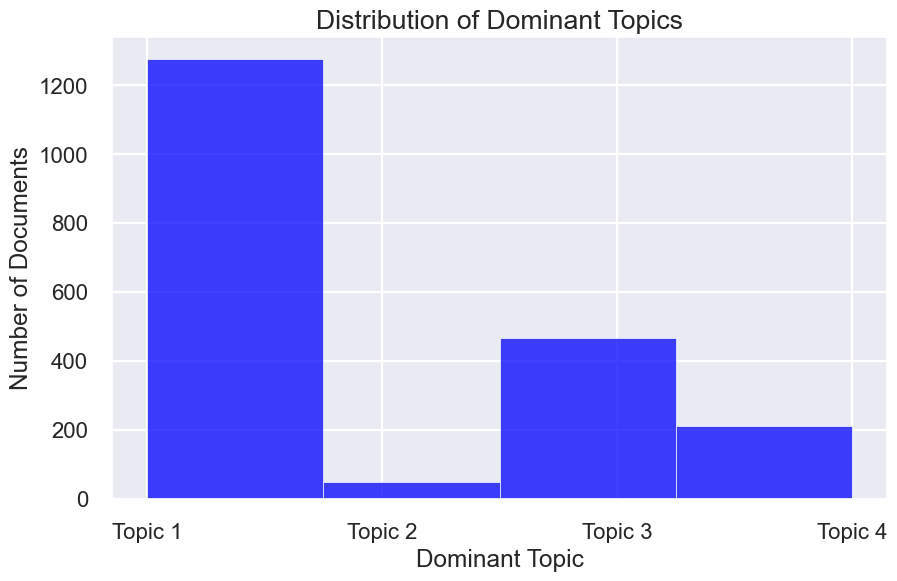

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(nmf_topics.argmax(axis=1), bins=num_topics, kde=False, color='blue')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Documents')
plt.title('Distribution of Dominant Topics')
plt.xticks(range(num_topics), labels=[f'Topic {i+1}' for i in range(num_topics)])
plt.show()

____

In [47]:
def map_topics(Topics):
    if Topics == 'Neutral':
        return 'climate change'
    elif Topics == 'News':
        return 'global warming'
    elif Topics == 'Pro':
        return 'believe think'
    elif Topics == 'Anti':
        return 'http climate'
    else:
        return Topics  # Handle other cases if needed

In [48]:
y_all = tweets['sentiment'].apply(map_topics)

# Modeling algorithm selection, model training and evaluation, results visualization, and interpretation

In [49]:
# Import necessary modules from sklearn for text vectorization, data splitting, model training, and evaluation
# Split the dataset into training and testing sets with a stratified split, ensuring class distribution is maintained
# Initialize TfidfVectorizer for converting text data into TF-IDF feature vectors, ignoring English stop words and considering both unigrams and bigrams
# Create a dictionary of pipelines, each containing a TF-IDF vectorizer followed by a classifier:
# - Linear Support Vector Classifier (LinearSVC)
# - Multinomial Naive Bayes (MNB)
# - k-Nearest Neighbors (kNN)
# - Random Forest (RF)
# - Logistic Regression (LR)
# Train each pipeline on the training data and evaluate its performance on the testing data
# Calculate weighted F1 score, precision, and recall for each model
# Store the evaluation metrics for each model in the scores dictionary
# Print classification reports for each model to show detailed evaluation metrics



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

X_all = tweets["message"]

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# TfidfVectorizer initialization
vecz = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))

# Creating Pipelines
pipelines = {
    "LinearSVC": Pipeline([("tf-idf", vecz), ("clf", LinearSVC(random_state=42))]),
    "MNB": Pipeline([("tf-idf", vecz), ("clf", MultinomialNB())]),
    "kNN": Pipeline([("tf-idf", vecz), ("clf", KNeighborsClassifier())]),
    "RF": Pipeline([("tf-idf", vecz), ("clf", RandomForestClassifier(random_state=42))]),
    "LR": Pipeline([("tf-idf", vecz), ("clf", LogisticRegression(random_state=42))])
}

# Fitting and Evaluating
scores = {}
for model_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    f1 = f1_score(y_test, predictions, average="weighted")
    precision = precision_score(y_test, predictions, average="weighted")
    recall = recall_score(y_test, predictions, average="weighted")

    scores[model_name] = {
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    }
    print(f"Model: {model_name}")
    print(classification_report(y_test, predictions))
    print("\n")

Model: LinearSVC
              precision    recall  f1-score   support

          -1       0.82      0.23      0.36        39
           0       0.57      0.38      0.46        78
           1       0.65      0.78      0.71       202
           2       0.56      0.65      0.61        81

    accuracy                           0.62       400
   macro avg       0.65      0.51      0.53       400
weighted avg       0.63      0.62      0.61       400



Model: MNB
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        39
           0       0.00      0.00      0.00        78
           1       0.51      1.00      0.68       202
           2       1.00      0.05      0.09        81

    accuracy                           0.52       400
   macro avg       0.38      0.26      0.19       400
weighted avg       0.46      0.52      0.36       400



Model: kNN
              precision    recall  f1-score   support

          -1       0.46      0.2

,F1 Score,Precision,Recall
LinearSVC,0.606485,0.634036,0.625
RF,0.557652,0.652064,0.575
LR,0.547796,0.551405,0.600
kNN,0.535384,0.543443,0.545
MNB,0.360229,0.460101,0.515


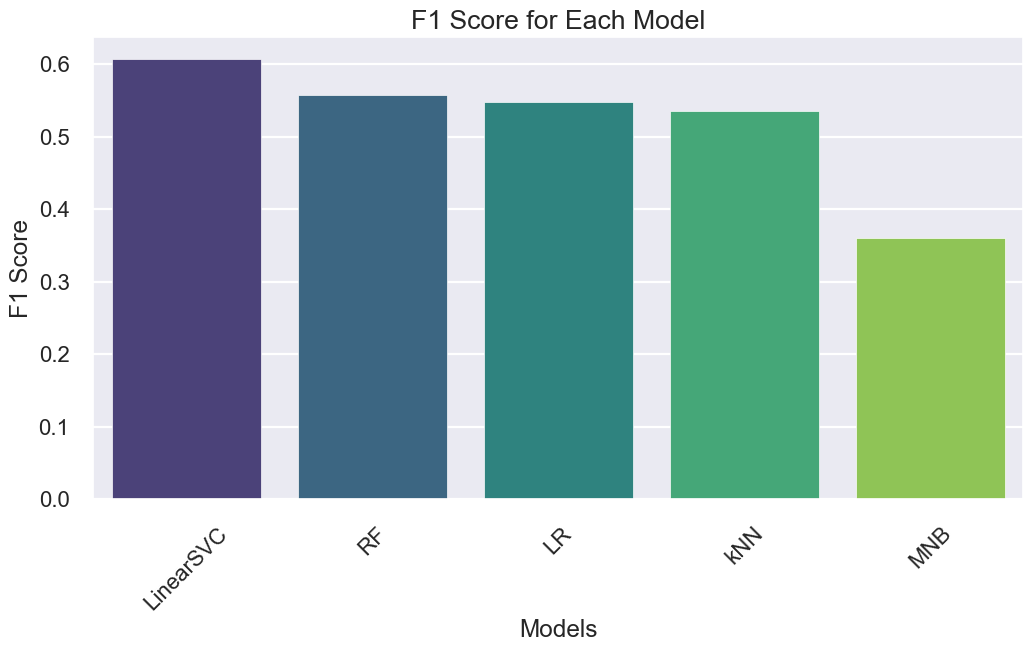

In [50]:
results = pd.DataFrame(scores).T
results = results.sort_values(by="F1 Score", ascending=False)
display(results)

import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=results.index, y="F1 Score", data=results, palette="viridis")
plt.title("F1 Score for Each Model")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.show()